<a href="https://colab.research.google.com/github/TishweeMahjong/CS370_Group2/blob/main/CS370_takehome_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PROBLEM SET 1 - TAKE AT HOME (25 POINTS)



## Introduction

In the last few years, the field of generative modeling has seen a lot of progress. The techniques that have been developed in this field are very useful for other tasks such as semi-supervised learning, representation learning, and reinforcement learning. In this problem statement we attempt to prepare you to understand the basics of a technique that has been very successful in generative modeling: Variational Autoencoders (VAEs). Understanding VAEs is  the key for you to get a head start with more advanced models such as [Stable Diffusion that are all the rage these days](https://clipdrop.co/stable-diffusion-turbo).



## Task 2: Replicate the VAE for the MNIST dataset (25 points)

Implement the VAE model for the MNIST dataset and train it ensuring that you plot the loss curves for the training and validation sets and perform hyperparameter optimization on the size of the latent space as well as on the optimizer parameters. To all points you need to include as comments in the code or as markdown cells what each function in the code is doing. Don't be frugal in your commentary. (15 points)

Replicate the figure showing the final latent variable space shown below. Note that you will not produce the animated figure shown below but show only the final latent space $(z_1, z_2)$. (5 points)

Show VAE generated images for all digits 0-9 after model training. (5 points)

![](latent-variables.gif)

### 2.1
Installing necessary packages and dependencies.

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist

### 2.2
Loading the MNIST dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train/255
X_test = X_test/255

# Convert from (no_of_data, 28, 28) to (no_of_data, 28, 28, 1)
X_train_new = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_new = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

11490434/11490434 [==============================] - 0s 0us/step


### 2.3
Building an encoder for the VAE in Keras.

Note: the latent space has two dimensions.

Convolution layers. \
Adding Dense layers i.e. create fully connected Dense layers in the neuural network.\
Introducing a function compute_latent() for reparametrization. This is done for sampling.

In [ ]:

img_height   = X_train_new.shape[1]    # 28
img_width    = X_train_new.shape[2]    # 28
num_channels = X_train_new.shape[3]    # 1
input_shape =  (img_height, img_width, num_channels)   # (28,28,1)
latent_dim = 2

encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2,
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

def compute_latent(x):
  mu, sigma = x
  batch = K.shape(mu)[0]
  dim = K.int_shape(mu)[1]
  eps = K.random_normal(shape=(batch,dim))
  return mu + K.exp(sigma/2)*eps

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
conv_shape = K.int_shape(encoder_conv)

### 2.4
Creating the decoder of the VAE.

Input layer required by the decoder.\
Adding a fully connected layer with ReLU activation function.\
Transposing convolutional layers to upsample data. \
Combining the encoder and the decoder to build the complete model.

In [ ]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2,
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2,
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3,
                          padding='same', activation='sigmoid')(decoder_conv)

encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

vae = Model(encoder_input, decoder(encoder(encoder_input)))

### 2.5
Loss function for training the VAE.

The loss function is comprised of a loss (BCE) and a KL divergence functions.\
Using the AdaM optimizer (Adaptive Momentum RMSprop) to compile the neural network.


In [ ]:
def kl_reconstruction_loss(true, pred):
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  return K.mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='adam', loss=kl_reconstruction_loss)
history = vae.fit(x=X_train_new, y=X_train_new, epochs=10, batch_size=8, validation_data=(X_test_new,X_test_new))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59952/60000 [============================>.] - ETA: 0s - loss: 175.8680

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 70s 1ms/sample - loss: 175.8559 - val_loss: 167.1061
Epoch 2/10
60000/60000 [==============================] - 55s 914us/sample - loss: 165.8607 - val_loss: 164.5879
Epoch 3/10
60000/60000 [==============================] - 55s 919us/sample - loss: 164.1298 - val_loss: 163.5341
Epoch 4/10
60000/60000 [==============================] - 61s 1ms/sample - loss: 163.1835 - val_loss: 162.8494
Epoch 5/10
60000/60000 [==============================] - 56s 930us/sample - loss: 162.5841 - val_loss: 162.3525
Epoch 6/10
60000/60000 [==============================] - 54s 905us/sample - loss: 162.1988 - val_loss: 162.1111
Epoch 7/10
60000/60000 [==============================] - 53s 888us/sample - loss: 161.8594 - val_loss: 162.4195
Epoch 8/10
60000/60000 [==============================] - 53s 886us/sample - loss: 161.6542 - val_loss: 161.4585
Epoch 9/10
60000/60000 [==============================] - 54s 896us/sample - loss: 161.5119 - val_loss: 161.396

### 2.6
Plotting graphs

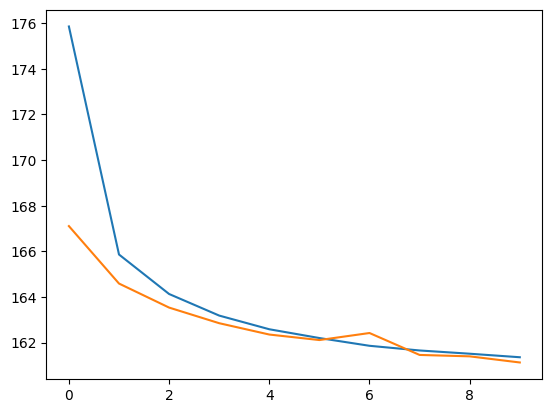

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

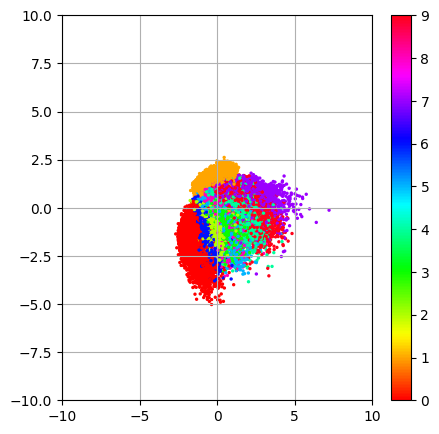

In [ ]:
encoded = encoder.predict(X_train_new)

plt.figure(figsize=(5,5))
plt.scatter(encoded[:,0], encoded[:,1], s=2, c=y_train, cmap='hsv')
plt.colorbar()
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid()
plt.show()

### 2.7

Function to generate images by interpolating between two points in latent space.

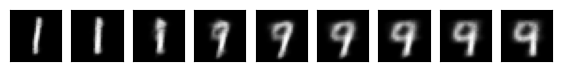

In [ ]:
def display_image_sequence(x_start,y_start,x_end,y_end,no_of_imgs):
    x_axis = np.linspace(x_start,x_end,no_of_imgs)
    y_axis = np.linspace(y_start,y_end,no_of_imgs)

    x_axis = x_axis[:, np.newaxis]
    y_axis = y_axis[:, np.newaxis]

    new_points = np.hstack((x_axis, y_axis))
    new_images = decoder.predict(new_points)
    new_images = new_images.reshape(new_images.shape[0], new_images.shape[1], new_images.shape[2])

    fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                             sharey=True, figsize=(7, 5))
    counter = 0
    for i in range(no_of_imgs):
        axes[counter].imshow(new_images[i], cmap='gray')
        axes[counter].get_xaxis().set_visible(False)
        axes[counter].get_yaxis().set_visible(False)
        counter += 1
    plt.show()

# starting point=(0,2); End point=(2,0); No of images=9
display_image_sequence(0,2,2,0,9)